In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import (KMeans, DBSCAN, AgglomerativeClustering, SpectralClustering,
                             Birch, MeanShift, AffinityPropagation, OPTICS, HDBSCAN)
from sklearn.mixture import GaussianMixture
from ast import literal_eval
import umap.umap_ as umap
from matplotlib.lines import Line2D
from scipy.spatial import ConvexHull
import matplotlib.patches as patches
import warnings

warnings.filterwarnings("ignore")

D:\4_course\VKR\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
results = pd.read_csv('clustering_results_1.csv')
df = pd.read_csv('preprocessed/prepared_data_nonumap.csv')
X_prepared = df.drop(columns=['КОД3 основной']).values
X_original = pd.read_excel('raw/RDBA_BEKHTEREV2.xlsx')
X_original = X_original.dropna(thresh=len(X_original.columns) * 0.155)
# X_original = X_original.dropna(thresh=len(X_original) * 0.1, axis=1)
X_original = X_original.drop(columns=['Id', 'КОД3 основной'])
true_labels = df['КОД3 основной'].values
scaling = True
dropping = True
methods_map = {
    'KMeans': KMeans, 'DBSCAN': DBSCAN, 'HDBSCAN': HDBSCAN, 'AgglomerativeClustering': AgglomerativeClustering,
    'SpectralClustering': SpectralClustering, 'Birch': Birch, 'MeanShift': MeanShift,
    'AffinityPropagation': AffinityPropagation, 'GaussianMixture': GaussianMixture,
    'OPTICS': OPTICS
}

In [11]:
def reduce_and_scale(X, params, scale=True, drop_features=None):
    method = params.pop('dimensionality_reduction', None)
    n_comp = None
    if drop_features is not None and len(drop_features) > 0:
        feature_names = df.drop(columns=['КОД3 основной']).columns
        drop_indices = [i for i, name in enumerate(feature_names) if name in drop_features]
        X = np.delete(X, drop_indices, axis=1)
    if method == 'PCA':
        n_comp = params.pop('pca_n_components')
        reducer = PCA(n_components=n_comp, random_state=42)
        X = reducer.fit_transform(X)
    elif method == 'UMAP':
        n_comp = params.pop('umap_n_components')
        reducer = umap.UMAP(
            n_components=n_comp,
            n_neighbors=params.pop('umap_n_neighbors'),
            min_dist=params.pop('umap_min_dist'),
            random_state=42
        )
        X = reducer.fit_transform(X)

    X = StandardScaler().fit_transform(X) if scale else X
    return X, method, n_comp

def cluster_and_label(method, params, X):
    model_cls = methods_map[method]
    if method == 'GaussianMixture':
        model = model_cls(**params, random_state=42)
        labels = model.fit(X).predict(X)
    else:
        model = model_cls(**params)
        labels = model.fit_predict(X)
    return labels

def draw_convex_hull(ax, points, color, alpha=0.1):
    if len(points) >= 3:
        try:
            hull = ConvexHull(points)
            ax.add_patch(patches.Polygon(points[hull.vertices], closed=True,
                                          facecolor=color, edgecolor=color,
                                          alpha=alpha, linewidth=1.5))
        except:
            pass

def prepare_2d(X):
    return TSNE(n_components=2, perplexity=30, random_state=42, max_iter=1000).fit_transform(X) if X.shape[1] > 2 else X

def plot_clusters(to_drop=True):
    n = len(results)
    fig, axes = plt.subplots((n + 1) // 2, 2, figsize=(12, n * 2.5))
    axes = axes.flatten()
    for i, row in results.iterrows():
        method = row['method']
        params = literal_eval(row['params'])
        score = row['best_score']
        metric = row['metric']
        drop_features = literal_eval(row.get('best_comb', '[]')) if to_drop else None
        X, red_method, n_comp = reduce_and_scale(X_prepared, params, scale=scaling, drop_features=drop_features)
        labels = cluster_and_label(method, params, X)
        X_2d = prepare_2d(X)
        ax = axes[i]
        scatter = ax.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, cmap='tab10', s=10)
        ax.legend(*scatter.legend_elements(), loc='best', fontsize=10)
        ax.set_title(f'{method} | {red_method} {str(n_comp)+' components ' if n_comp is not None else ''}| score={score:.3f} ({metric})', fontsize=11)
        ax.set_xticks([]), ax.set_yticks([])
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    plt.tight_layout()
    plt.savefig('cluster_visualizations.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_convex_hulls(to_drop=True, true_label_to_color=None, true_label_to_name=None):
    unique_true = np.unique(true_labels)
    
    if true_label_to_color is None:
        true_label_to_color = {label: plt.cm.tab10(i % 10) for i, label in enumerate(unique_true)}
    if true_label_to_name is None:
        true_label_to_name = {label: f'Class {label}' for label in unique_true}

    n = len(results)
    fig, axes = plt.subplots((n + 1) // 2, 2, figsize=(13, n * 3))
    axes = axes.flatten()
    
    for i, row in results.iterrows():
        method = row['method']
        params = literal_eval(row['params'])
        score = row['best_score']
        metric = row['metric']
        drop_features = literal_eval(row.get('best_comb', '[]')) if to_drop else None
        
        X, red_method, n_comp = reduce_and_scale(X_prepared, params, scale=scaling, drop_features=drop_features)
        labels = cluster_and_label(method, params, X)
        X_2d = prepare_2d(X)
        ax = axes[i]
        
        for label in np.unique(labels):
            draw_convex_hull(ax, X_2d[labels == label], plt.cm.tab20(label % 20))
        
        for label in unique_true:
            idx = true_labels == label
            color = true_label_to_color.get(label, 'gray')
            ax.scatter(X_2d[idx, 0], X_2d[idx, 1], c=[color] * np.sum(idx),
                       marker='o', s=25)
        
        legend_elements = [
            Line2D([0], [0], marker='o', color='w', 
                   label=true_label_to_name.get(label, f'Class {label}'),
                   markerfacecolor=true_label_to_color.get(label, 'gray'), markersize=6)
            for label in unique_true
        ]
        ax.legend(handles=legend_elements, loc='upper right', fontsize=8)
        ax.set_title(f'{method} | {red_method} {str(n_comp)+' components ' if n_comp is not None else ''}| score={score:.3f} ({metric})', fontsize=11)
        ax.set_xticks([]), ax.set_yticks([])
    
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.savefig('convex_hulls.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_heatmaps(by_cluster_size=False, to_drop=True):
    n = len(results)
    fig, axes = plt.subplots((n + 1) // 2, 2, figsize=(13, n * 3))
    axes = axes.flatten()
    for i, row in results.iterrows():
        method = row['method']
        params = literal_eval(row['params'])
        drop_features = literal_eval(row.get('best_comb', '[]')) if to_drop else None
        X, _, _ = reduce_and_scale(X_prepared, params, scale=scaling, drop_features=drop_features)
        labels = cluster_and_label(method, params, X)
        unique_clusters = np.unique(labels)
        data = []
        for cluster in unique_clusters:
            cluster_data = true_labels[labels == cluster]
            if by_cluster_size:
                total = len(cluster_data)
                row_data = [(cluster_data == label).sum() / total * 100 for label in np.unique(true_labels)]
            else:
                row_data = [(cluster_data == label).sum() / (true_labels == label).sum() * 100
                            for label in np.unique(true_labels)]
            data.append(row_data)
        df_percent = pd.DataFrame(data, columns=np.unique(true_labels), index=unique_clusters)
        ax = axes[i]
        sns.heatmap(df_percent, annot=True, fmt=".2f", cmap="Blues", cbar=True, ax=ax, linewidths=0.5)
        ax.set_title(f'{method} | Score={row["score"]:.3f} ({row["metric"]})', fontsize=11)
        ax.set_ylabel('Cluster'), ax.set_xlabel('True Class')
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    fig.suptitle('Распределение классов по кластерам, %', fontsize=14, y=1)
    plt.tight_layout()
    plt.savefig('heatmaps.png', dpi=300, bbox_inches='tight')
    plt.show()

def compute_silhouette_scores(to_drop=True):
    scores = []
    for _, row in results.iterrows():
        method = row['method']
        params = literal_eval(row['params'])
        drop_features = literal_eval(row.get('best_comb', '[]')) if to_drop else None
        X, _, _ = reduce_and_scale(X_prepared, params, scale=scaling, drop_features=drop_features)
        labels = cluster_and_label(method, params, X)
        if method != 'DBSCAN' or np.any(labels != -1):
            score = silhouette_score(X, labels)
            scores.append({'method': method, 'score': score})
    return pd.DataFrame(scores).sort_values(by='score', ascending=False)

def compute_cluster_means(to_drop=True):
    cluster_means = {}
    for _, row in results.iterrows():
        method = row['method']
        params = literal_eval(row['params'])
        drop_features = literal_eval(row.get('best_comb', '[]')) if to_drop else None
        X, _, _ = reduce_and_scale(X_prepared, params, scale=scaling, drop_features=drop_features)
        labels = cluster_and_label(method, params, X)
        
        cluster_means_method = {}
        for cluster in np.unique(labels):
            cluster_data = X_original[labels == cluster]
            cluster_means_method[cluster] = np.nanmean(cluster_data, axis=0)

        cluster_means[method] = cluster_means_method
    
    return cluster_means

def save_cluster_means_to_excel(cluster_means, X_original, filename="cluster_means.xlsx"):
    column_names = X_original.columns
    with pd.ExcelWriter(filename) as writer:
        for method, cluster_means_method in cluster_means.items():
            rows = []
            for cluster, means in cluster_means_method.items():
                row = {'cluster': cluster, **{column_names[i]: mean for i, mean in enumerate(means)}}
                rows.append(row)

            df = pd.DataFrame(rows)
            df.to_excel(writer, sheet_name=method, index=False)

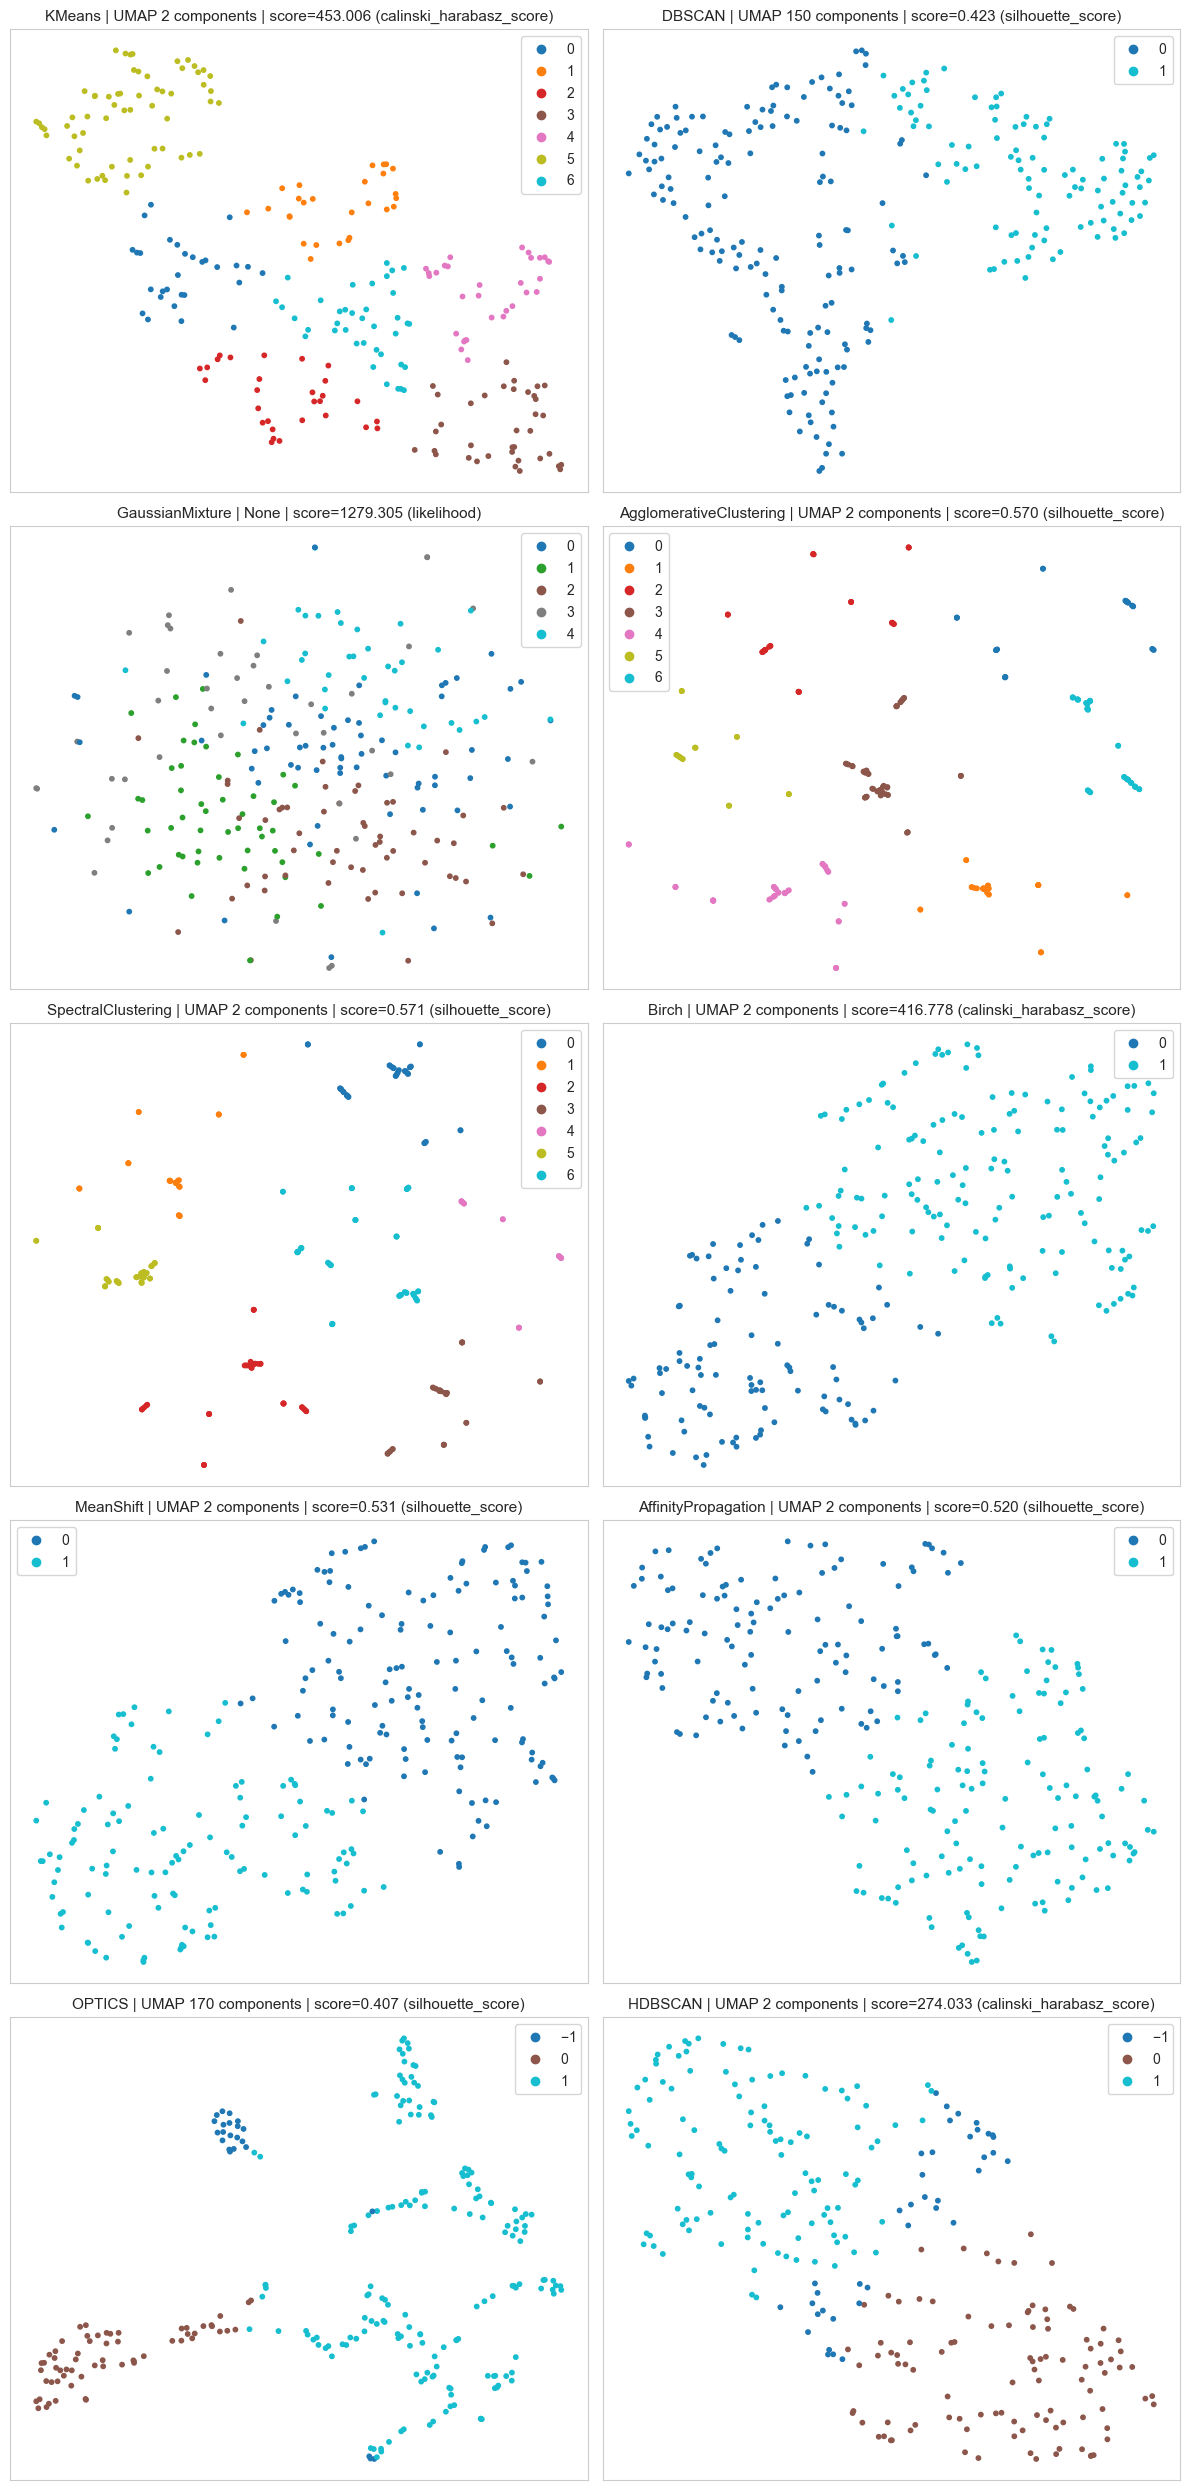

In [4]:
plot_clusters()

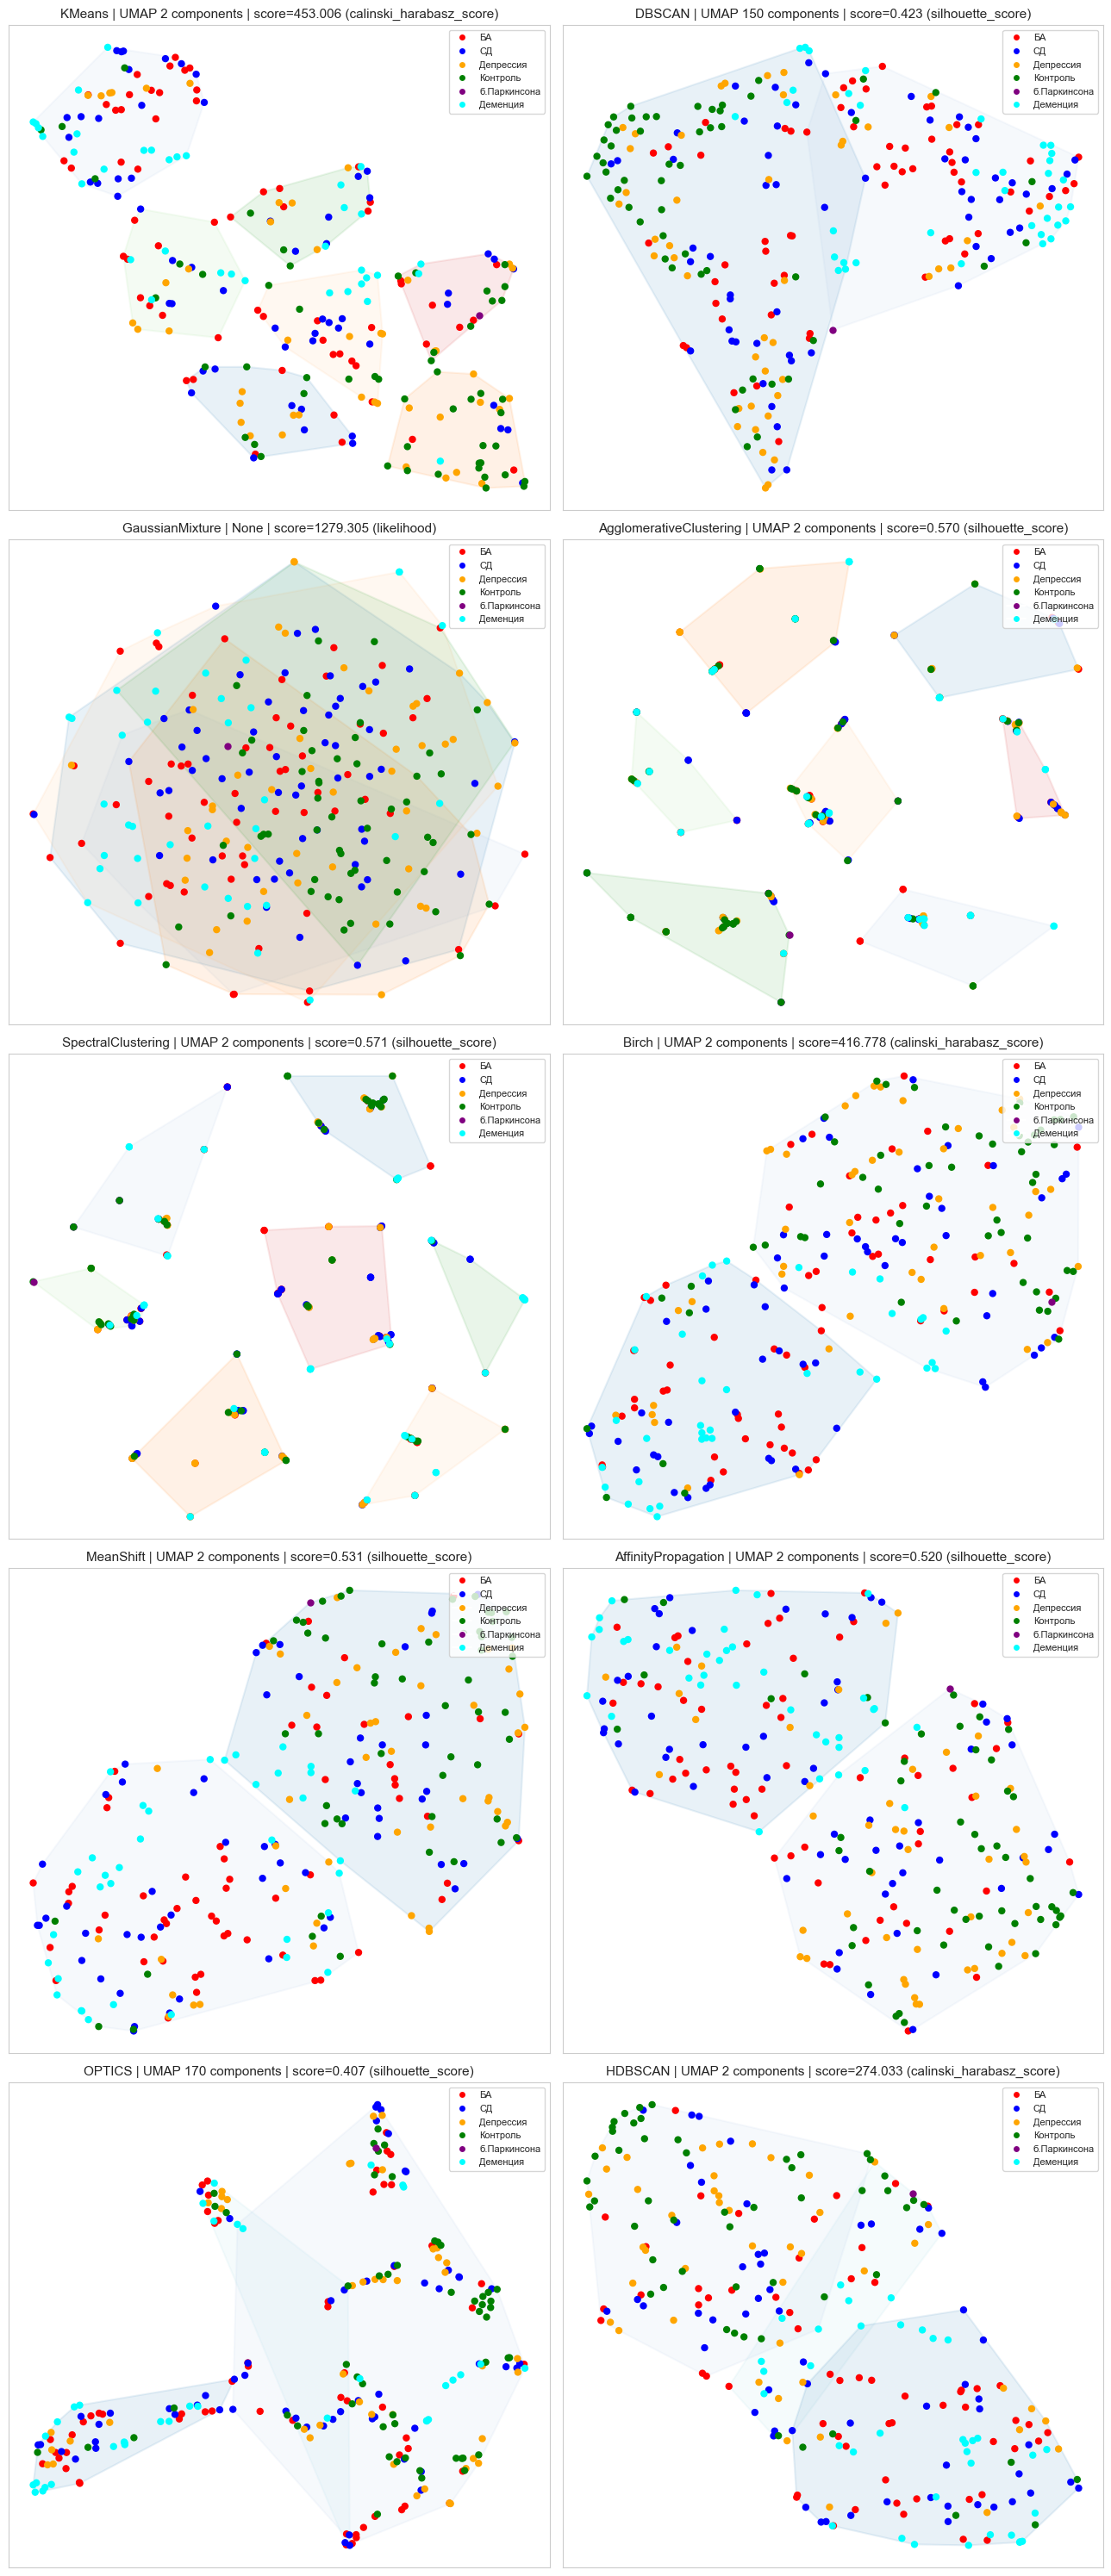

In [5]:
true_label_to_color = {
    1: 'red',
    2: 'blue',
    3: 'orange',
    4: 'green',
    5: 'purple',
    6: 'cyan'    
}

true_label_to_name = {
    1: 'БА',
    2: 'СД',
    3: 'Депрессия',
    4: 'Контроль',
    5: 'б.Паркинсона',
    6: 'Деменция'
}

plot_convex_hulls(to_drop=True, true_label_to_color=true_label_to_color, true_label_to_name=true_label_to_name)

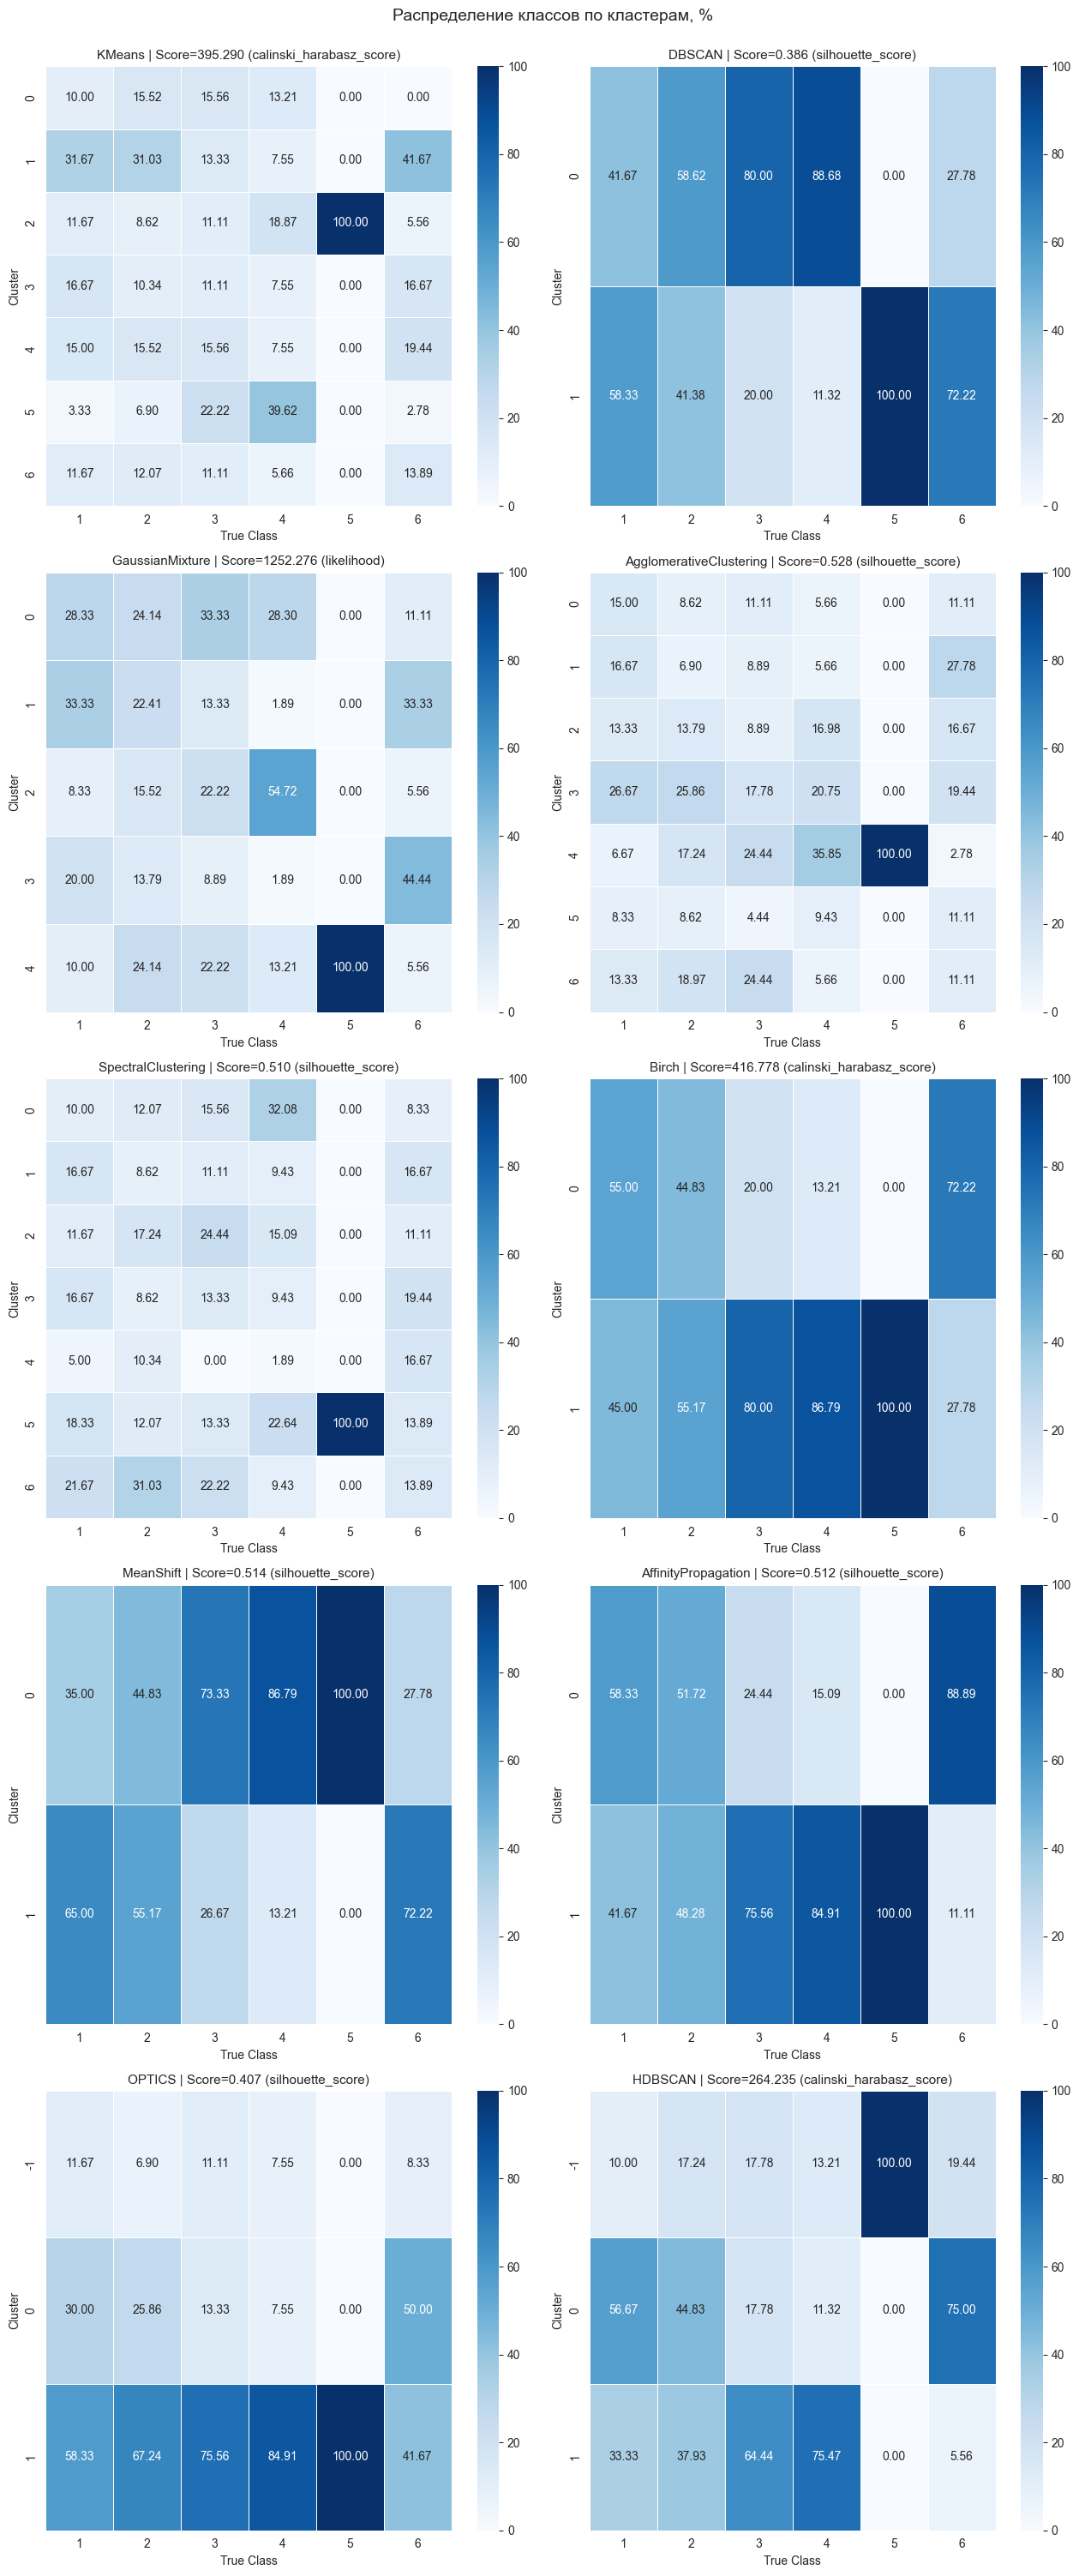

In [12]:
plot_heatmaps(by_cluster_size=False)

In [7]:
compute_silhouette_scores()

,method,score
4,SpectralClustering,0.545058
3,AgglomerativeClustering,0.542924
5,Birch,0.519815
6,MeanShift,0.503689
7,AffinityPropagation,0.498009
0,KMeans,0.481821
1,DBSCAN,0.423038
8,OPTICS,0.406920
9,HDBSCAN,0.338705
2,GaussianMixture,-0.002911


In [8]:
cluster_means = compute_cluster_means()
save_cluster_means_to_excel(cluster_means, X_original, "cluster_means.xlsx")